In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from matplotlib import pyplot as plt

# Import data

In [2]:
import os
import glob

df=pd.DataFrame()
for filepath in glob.glob(os.path.join('raw_data', '*.txt')):
    tmp=pd.read_csv(filepath,header=None)
    tmp.columns=['Trial','ChartType','RealRatio','InputRatio','indexDif']
    tmp['Name']=filepath[9:][:-4]
    if len(df)==0:
        df=tmp
    else:
        df=df.append(tmp).reset_index(drop=True)
df.head(3)

,Trial,ChartType,RealRatio,InputRatio,indexDif,Name
0,1,Bubble,0.608244,0.9,0,MeijieWang
1,2,Bubble,0.548130,0.7,0,MeijieWang
2,3,Pie,0.600000,0.7,8,MeijieWang


# Compute error

In [3]:
#compute error
error=abs(df.RealRatio-df.InputRatio)*100+(1/8)
error[error<1]=1
df['log']=pd.DataFrame(np.log2(error))
df.head(5)

,Trial,ChartType,RealRatio,InputRatio,indexDif,Name,log
0,1,Bubble,0.608244,0.9,0,MeijieWang,4.872858
1,2,Bubble,0.548130,0.7,0,MeijieWang,3.936590
2,3,Pie,0.600000,0.7,8,MeijieWang,3.339850
3,4,Bubble,0.594684,0.6,0,MeijieWang,0.000000
4,5,Line,0.567568,0.5,2,MeijieWang,2.782777


# Divide data by chartType

In [4]:
#Divide data by chartType
Piedf=df[df.ChartType=="Pie"].reset_index(drop=True)
Bubbledf=df[df.ChartType=="Bubble"].reset_index(drop=True)
Linedf=df[df.ChartType=="Line"].reset_index(drop=True)

# Average error

In [7]:
summary=pd.DataFrame()
summary['Type']=["Pie","Bubble","StackedArea"]
summary['AvgLogError']=[Piedf.log.mean(),Bubbledf.log.mean(),Linedf.log.mean()]
summary

,Type,AvgLogError
0,Pie,2.610264
1,Bubble,3.127869
2,StackedArea,3.592643


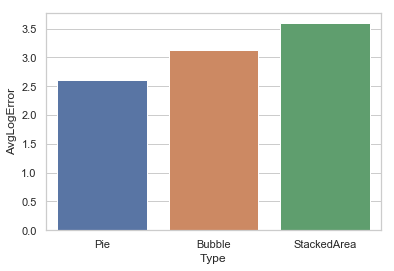

In [9]:
sns.set(style="whitegrid")
x = sns.barplot(x="Type", y="AvgLogError", data=summary)
plt.savefig('AvgError.png', dpi=1800)

# Bootstrapped  CI

In [13]:
def bootstrapList(df,n=None):
    """ Bootstrap resample mean array
    Parameters
    ----------
    df : a dataframe wigh "log" column
    n : int, optional
      length of resampled array, equal to len(X) if n==None
      
    Results
    -------
    returns resamples log error mean array
    """
    length=len(df)
    if n==None:
        n=length
    indexArray=np.random.randint(0,length,n)
    resample=np.array(df.log)[indexArray]
    return resample

#95% CI
def CI(Array):
    n=len(Array)
    mean=Array.mean()
    std=Array.std()
    cih=mean + 1.96*std/math.sqrt(n)
    cil=mean - 1.96*std/math.sqrt(n)
    return cil,cih

In [14]:
PieBS=bootstrapList(Piedf,n=1000)
PieCIL,PieCIH=CI(PieBS)
LineBS=bootstrapList(Linedf,n=1000)
LineCIL,LineCIH=CI(LineBS)
BubbleBS=bootstrapList(Bubbledf,n=1000)
BubbleCIL,BubbleCIH=CI(BubbleBS)
summary['CIL']=[PieCIL,BubbleCIL,LineCIL]
summary['CIH']=[PieCIH,BubbleCIH,LineCIH]
summary

,Type,AvgLogError,CIL,CIH
0,Pie,2.610264,2.508059,2.690100
1,Bubble,3.127869,3.037201,3.210938
2,StackedArea,3.592643,3.423852,3.613164


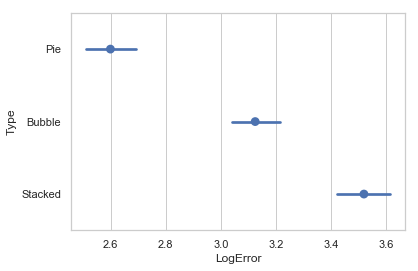

In [23]:
CI=pd.DataFrame()
CI['LogError']=PieBS
CI['Type']="Pie"
LineCI=pd.DataFrame()
LineCI['LogError']=LineBS
LineCI['Type']="Stacked"
BubbleCI=pd.DataFrame()
BubbleCI['LogError']=BubbleBS
BubbleCI['Type']="Bubble"
CI=CI.append(BubbleCI).reset_index(drop=True)
CI=CI.append(LineCI).reset_index(drop=True)

ax = sns.pointplot(x="LogError", y="Type", data=CI, join=False,ci=95)
plt.savefig('BSCI.png', dpi=1800)
